# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [4]:
import pandas as pd

In [5]:
Tilapia_UN = pd.read_excel('./data/calamansi_UN.xlsx')

In [6]:
Tilapia_DA = pd.read_excel('./data/calamansi_DA.xlsx')

In [7]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,847,Calamansi - Retail,5,KG,5,2020,83.54
1,847,Calamansi - Retail,5,KG,5,2020,60.00
2,847,Calamansi - Retail,5,KG,5,2020,77.50
3,847,Calamansi - Retail,5,KG,5,2020,77.07
4,847,Calamansi - Retail,5,KG,5,2020,147.14
...,...,...,...,...,...,...,...
957,847,Calamansi - Retail,5,KG,6,2021,70.00
958,847,Calamansi - Retail,5,KG,6,2021,66.88
959,847,Calamansi - Retail,5,KG,6,2021,73.75
960,847,Calamansi - Retail,5,KG,6,2021,87.50


In [8]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Calamansi - Retail,NaN,KG,1,2022,78.11
1,NaN,Calamansi - Retail,NaN,KG,2,2022,90.52
2,NaN,Calamansi - Retail,NaN,KG,3,2022,100.15
3,NaN,Calamansi - Retail,NaN,KG,4,2022,100.06
4,NaN,Calamansi - Retail,NaN,KG,5,2022,87.95


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [9]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_UN.head()

,mp_price,date
0,83.54,2020-05-15
1,60.00,2020-05-15
2,77.50,2020-05-15
3,77.07,2020-05-15
4,147.14,2020-05-15


### DA Bantay Presyo

In [12]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [13]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [14]:
Tilapia_DA.head()

,mp_price,date
0,78.11,2022-01-15
1,90.52,2022-02-15
2,100.15,2022-03-15
3,100.06,2022-04-15
4,87.95,2022-05-15


In [15]:
import matplotlib.pyplot as plt

In [16]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

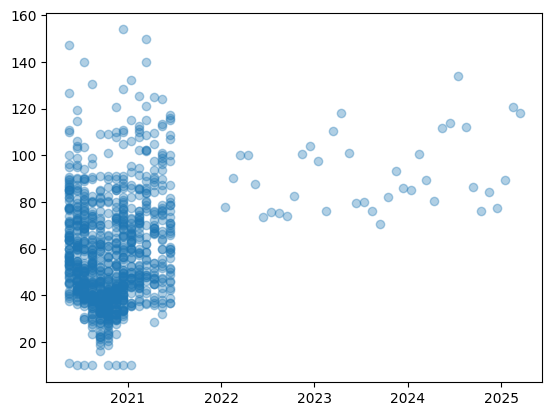

<Figure size 5000x600 with 0 Axes>

In [17]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [18]:
from datetime import datetime

In [19]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [20]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [21]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [22]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

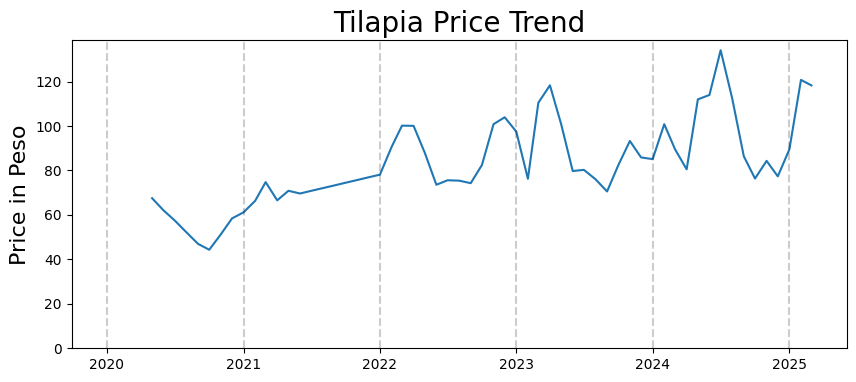

In [23]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [24]:
first_diff = lim_tilapia.diff()[1:]

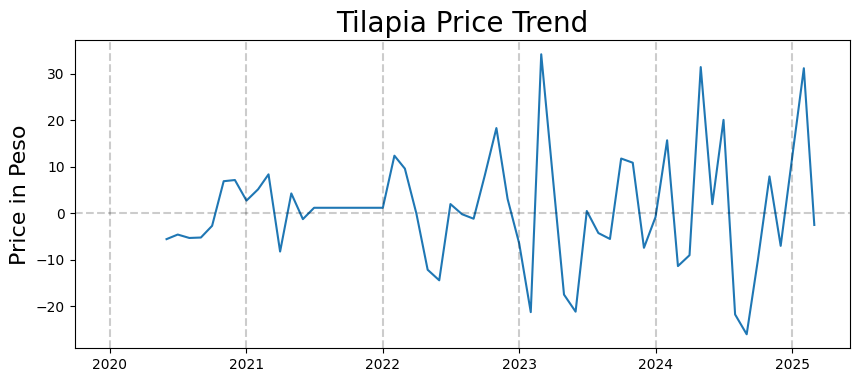

In [25]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [26]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

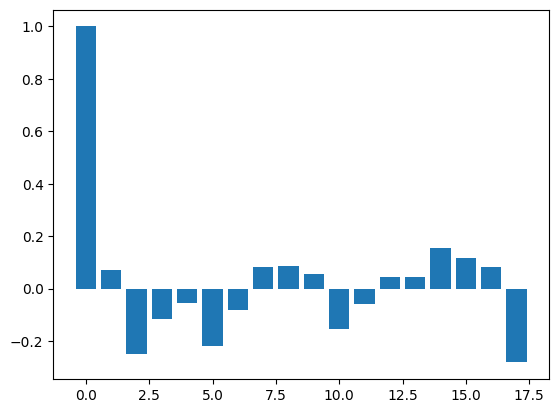

In [27]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

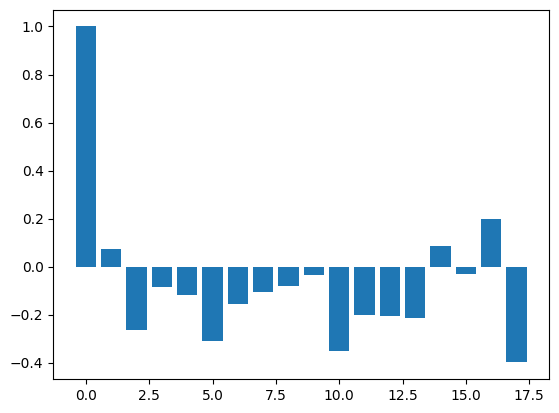

In [28]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [29]:
from datetime import timedelta

In [30]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [31]:
Tilapia.describe()

,mp_price
count,59.000000
mean,82.845145
std,19.344214
min,44.317859
25%,71.449060
50%,78.110000
75%,95.355000
max,134.070000


## Fit the SARIMA Model

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [34]:
from time import time

In [35]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.9819724559783936


In [36]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -202.224
Date:                              Thu, 22 May 2025   AIC                            410.448
Time:                                      19:37:18   BIC                            416.302
Sample:                                  05-01-2020   HQIC                           412.693
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0546     12.365     -0.004      0.996     -24.289      24.180
ma.S.L12       0.03

In [37]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01     76.36
2024-11-01     84.31
2024-12-01     77.34
2025-01-01     89.52
2025-02-01    120.73


In [38]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [39]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [40]:
predictions

date
2024-10-01    86.093671
2024-11-01    85.846334
2024-12-01    86.025394
2025-01-01    86.039052
2025-02-01    85.647120
2025-03-01    85.942827
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
residuals

date
2024-10-01    -9.733671
2024-11-01    -1.536334
2024-12-01    -8.685394
2025-01-01     3.480948
2025-02-01    35.082880
2025-03-01    32.307173
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

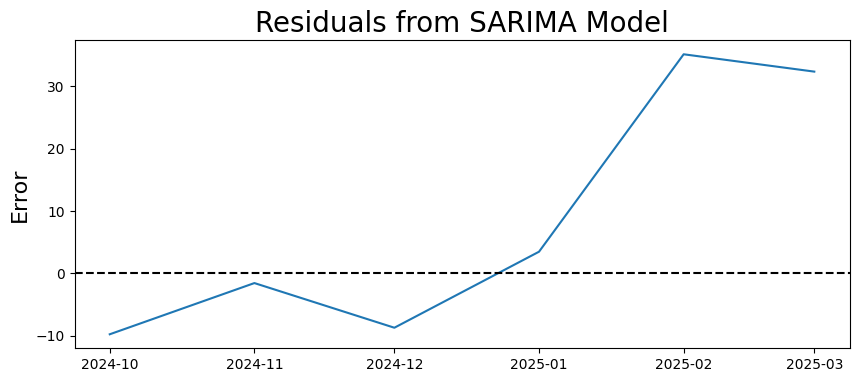

In [42]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

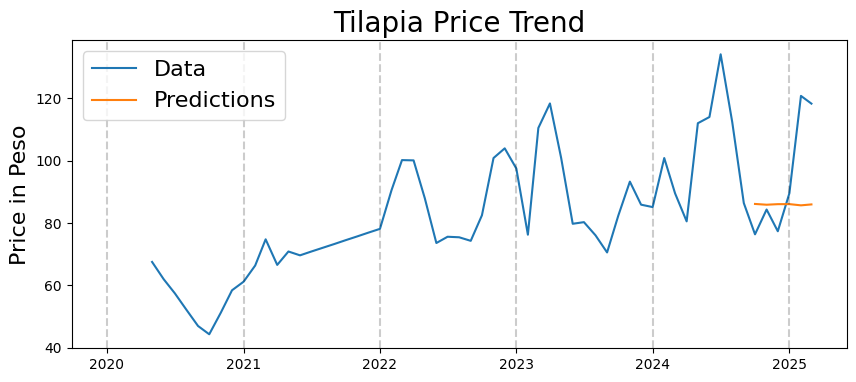

In [43]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [44]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipykernel_24921/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_24921/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_24921/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_24921/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_24921/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will

In [45]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

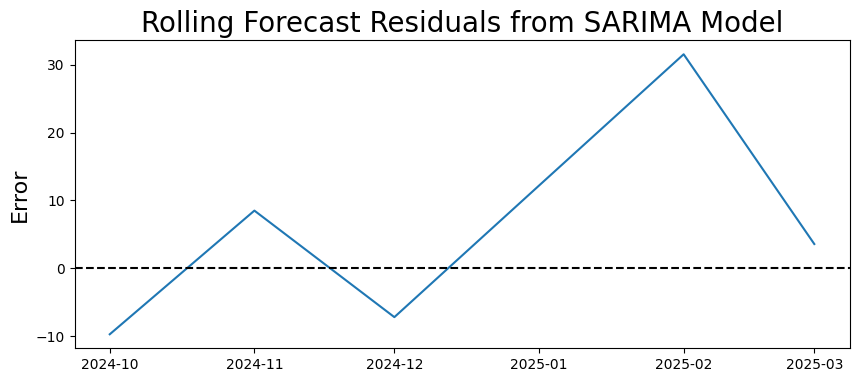

In [46]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

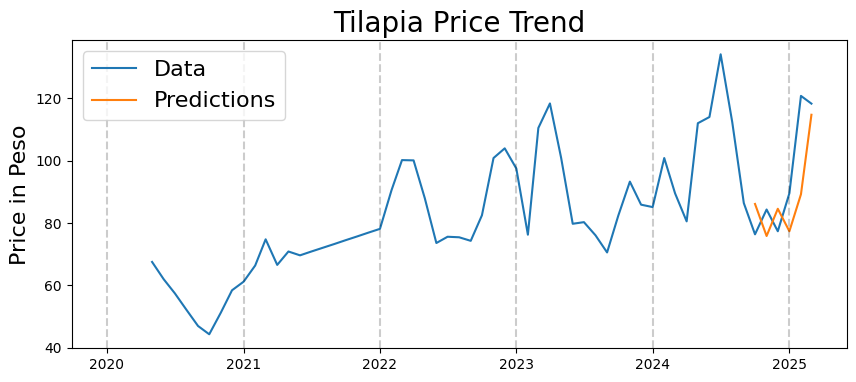

In [47]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [48]:
import numpy as np

In [49]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.1248


In [50]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 15.131503837845928


## Future Predictions (2025)

In [51]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [52]:
predictions

2025-03-01    114.683834
2025-04-01    112.949133
2025-05-01    118.476434
2025-06-01    119.734261
2025-07-01    122.706095
2025-08-01    119.168260
2025-09-01    115.002240
2025-10-01    112.330263
2025-11-01    114.777953
2025-12-01    115.547629
2026-01-01    116.962202
2026-02-01    116.356995
Freq: MS, Name: predicted_mean, dtype: float64

In [53]:
residuals

2024-10-01         NaN
2024-11-01         NaN
2024-12-01         NaN
2025-01-01         NaN
2025-02-01         NaN
2025-03-01    3.566166
2025-04-01         NaN
2025-05-01         NaN
2025-06-01         NaN
2025-07-01         NaN
2025-08-01         NaN
2025-09-01         NaN
2025-10-01         NaN
2025-11-01         NaN
2025-12-01         NaN
2026-01-01         NaN
2026-02-01         NaN
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

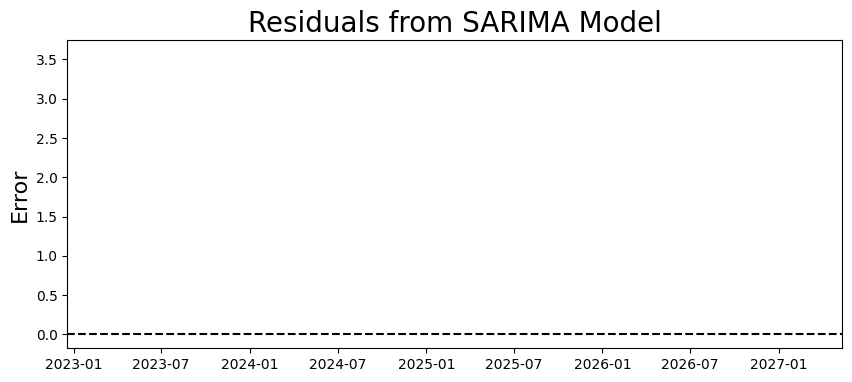

In [54]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

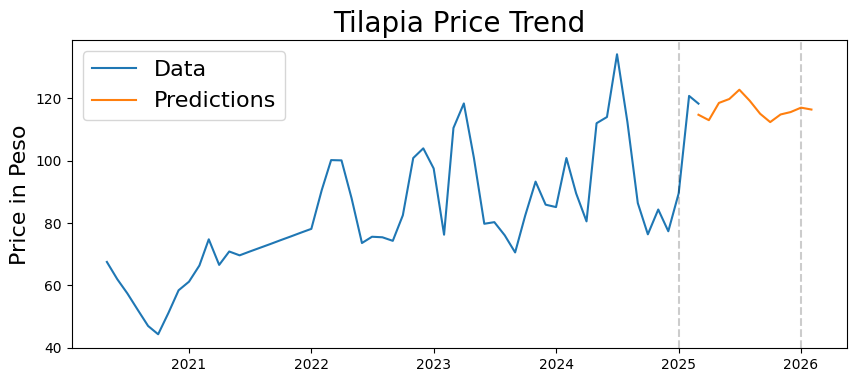

In [55]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(2025,2027):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [56]:
# Tilapia 100g
# Protein = 19g
protein = 0.7*10
# Carbohydrates = 0g
carbs = 8.4*10
# Fats = 2.48 g
fats = 0.2*10
# Fiber 0g
fiber = 1.9*10

In [57]:
protein_projection = protein / predictions

Text(0, 0.5, 'Protein in Grams')

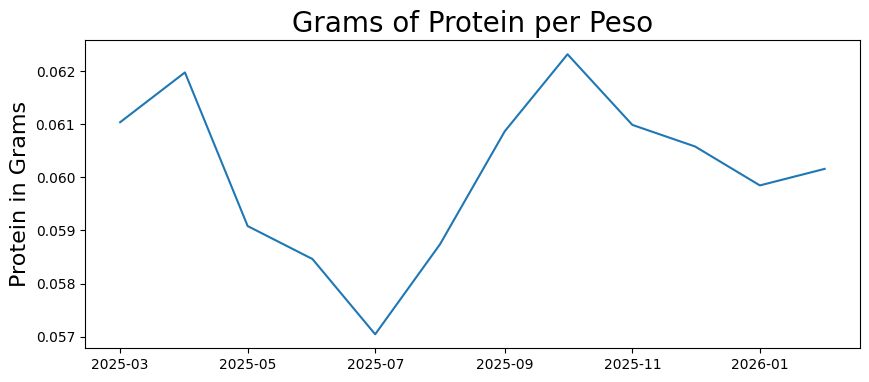

In [58]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [59]:
carbs_projection = carbs / predictions

Text(0, 0.5, 'Protein in Grams')

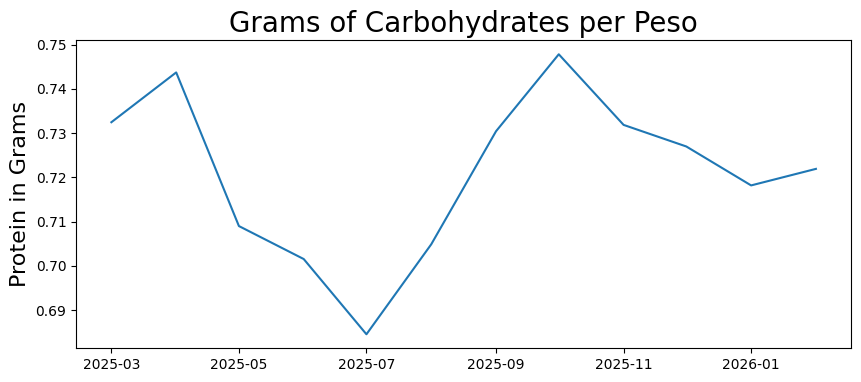

In [60]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [61]:
fats_projection = fats / predictions

Text(0, 0.5, 'Protein in Grams')

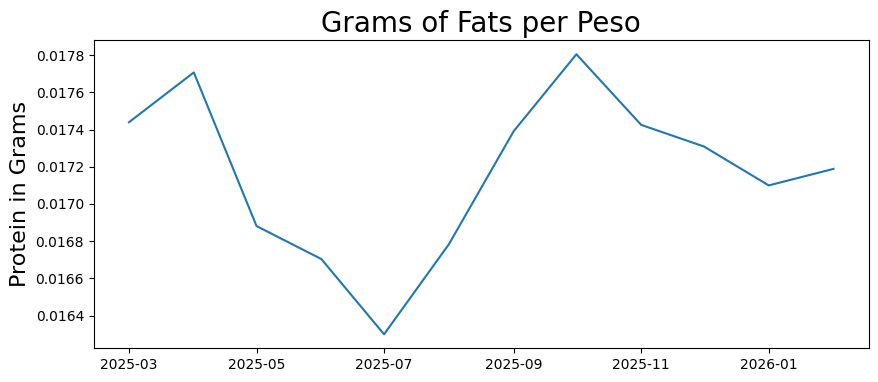

In [62]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [63]:
fiber_projection = fiber / predictions

Text(0, 0.5, 'Protein in Grams')

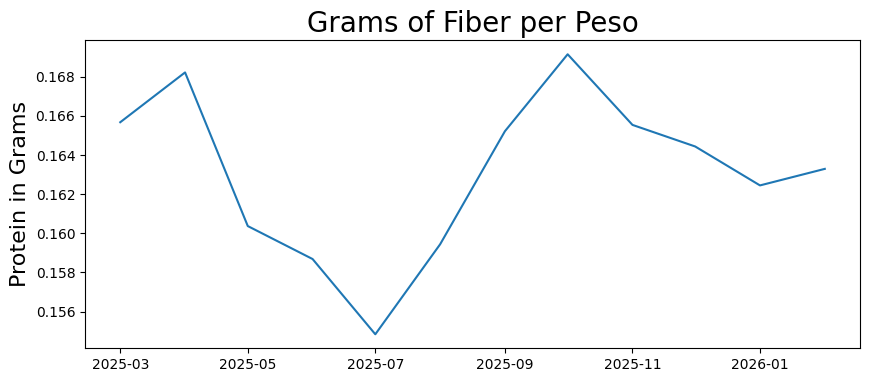

In [64]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [65]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)